# O Algoritmo DBScan

In [331]:
import IPython
IPython.display.Video('dbscan-example-blobs.mp4',embed=True,html_attributes="loop autoplay controls style='width: 100%'")

## 1. Introdução

É meio evidente que existem 4 grupos distintos na figura acima e o algoritmo DBScan é uma das muitas formas de tentar dotar as máquinas desse nível de percepção e neste notebook vamos explicar como ele funciona. 

O diferencial de ensinar a máquina a fazer este tipo de associação é que a mesma técnica pode ser aplicada em conjuntos de dados com milhões de registros e/ou com milhares de váriaveis, algo que nós - seres humanos - não conseguimos fazer em tempo hábil. 

### 1.1. Funcionamento do Algoritmo

A figura abaixo demonstra como o DBScan alcança este resultado.

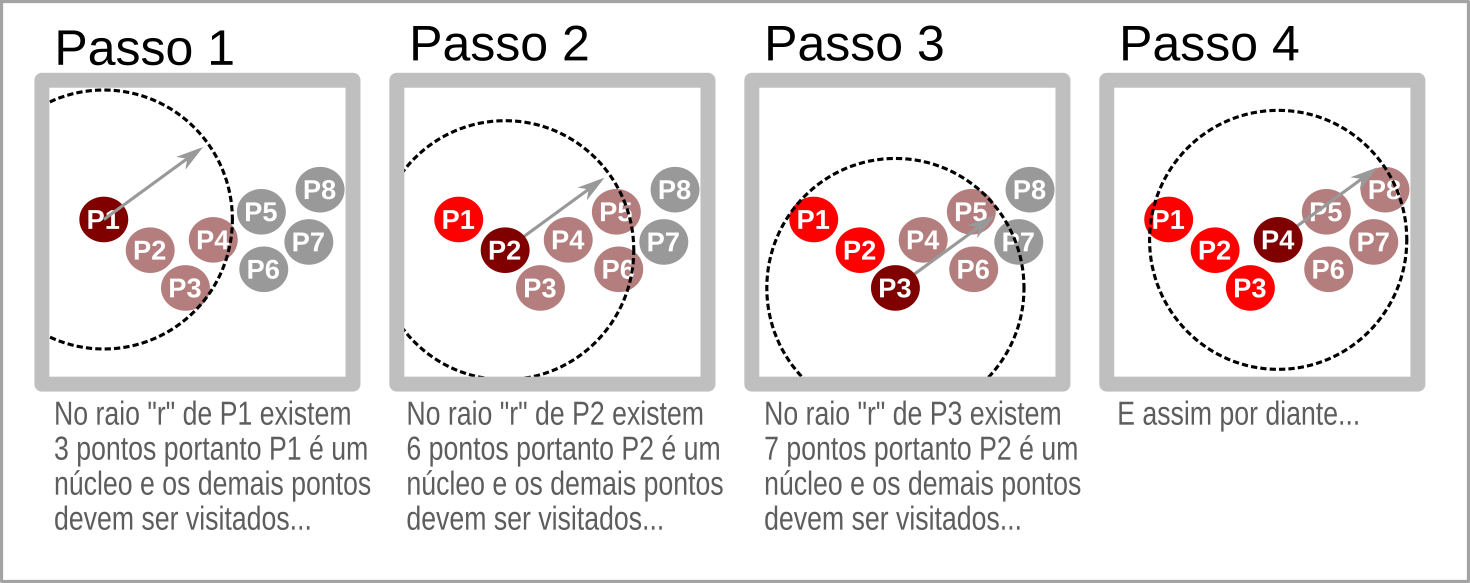

Em resumo o algoritmo encontra pontos não processados, verifica se a densidade é suficiente, se for o caso navega para os vizinhos dentro do circulo fazendo o mesmo cálculo até que não sejam encontrados mais vizinhos. 

### 1.2. Outras implementações e referências

Este notebook contém uma implementação desse algoritmo para fins didáticos. Para uso em produção, sugerimos usar uma implementação mais madura como o [sklearn.cluster.DBSCAN][1]. O artigo [Wikipedia DBSCAN article][2] tem uma boa explicação do algoritmo DBSCAN, bem como variações e referências para maiores detalhes. 

  [1]: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
  [2]: https://en.wikipedia.org/wiki/DBSCAN


## 2. Funcionamento do Algoritmo

Em resumo, o algoritmo funciona da seguinte forma:

    Parâmetros:
       X - conjunto de pontos para cálculo dos agrupamentos
       minPts - número mínimo de pontos dentro do circulo       
       radius - raio do ciculo
    Resultados:
       Y     - lista de cluster_id gerados pelo modelo 
               (0=outlier)
       cores - lista de indicadores de core/borda gerados pelo modelo 
               (0=outlier/borda; 1=core)
              
    cluster_id = 0
        
    LOOP1: Para cada ponto "x1" no conjunto "X":
     |
     |  SE x1 já foi tratado, ignora o resto deste bloco e 
     |    passa ao tratamento do proximo elemento do LOOP1
     |
     |  N1 = lista de pontos em "X" com distância para "x1" menor que "radius"
     |
     |  SE N1 contém mais de "minPts" pontos:
     |   |
     |   |  incrementa "cluster_id"
     |   |
     |   |  marca "x1" como "core" do cluster "cluster_id"
     |   |
     |   |  LOOP2: Para cada ponto "x2" no conjunto "N1":
     |   |   |                     o conjunto N1 irá crescer a medida que novos
     |   |   |                     vizinhos são descobertos no corpo desse loop
     |   |   |
     |   |   |  SE "x2" é um "core" de outro cluster ignora o resto deste bloco e 
     |   |   |                                 passa ao próximo elemento do LOOP2
     |   |   |
     |   |   |  "N2" = lista de pontos em "X" com distância para "x2" menor que "radius"
     |   |   |  
     |   |   |  SE "N2" contém mais de "minPts" pontos:
     |   |   |   |
     |   |   |   |  marca "x2" como um "core" do cluster "cluster_id"
     |   |   |   |
     |   |   |   |  adiciona os pontos "N2" aos vizinhos "N1" (ignorando duplicatas)
     |   |   |   |                 estes vizinhos são incluídos em "N1" para que o 
     |   |   |   |                 LOOP2 continue enquanto houverem pontos próximos
     |   |   |   |                 aos núcleos desse cluster. 
     |   |   |   |
     |   |   |  CASO CONTRÁRIO
     |   |   |   |
     |   |   |   |  marca "x2" como uma "borda" do cluster "cluster_id"
    
     
   
### 2.1 Implementação Python

Abra a célula abaixo para ver o código fonte.

In [280]:
import random
import math
import numpy as np
import pandas as pd
import scipy
import time     
        
def fit_dbscan_iterable( X, minPts=3, radius=1, verbose=True, anim=True, animFrames=100, animFramesAfter=40, animFramesBefore=10  ):
    """Find clusters using dbscan algorithm
    
    Parameters
    ----------
    X : list of points
        array of points to find the clusters in (accept: list, numpy or pandas)
    minPts : int (default=3)
        minimum points to be considered a core 
    radius : float (default=1)
        radius to find neighbors
    verbose : bool (default=True)
        print some messages during processing
    anim : bool (default=True)
        return intermediary frames to make a animation
        
    Returns
    -------
    generator object -> (y, cores, cursor)
        returns a generator object (iterable) that will
        return a tuple of (y, cores and cursor) for
        each frame   
        
    """
    
    # padronização dos dados de entrada
    radius = float(radius)
    
    if isinstance( X, pd.DataFrame ):
        X = X.to_numpy()    
    
    # Esta função localiza os vizinhos do ponto X1
    def locate_neigbors( x1 ):
        nonlocal X, radius
        result = []
        
        for x2i, x2 in enumerate( X ):
            d = scipy.spatial.distance.euclidean( x1, x2 )
            if d < radius:
                result.append( [ x2i, x2 ] )
                
        return result; 
    
    # calcula o interval entre frames para que a animação tenha ~ 100 frames
    animEach = len(X)/animFrames
    animFrame = 0;
    
    # dados gerais
    cluster_id = 0    
    y = [ 0 for _ in X ]
    cores = [ 0 for _ in X ]    
        
    # se for necessário processar em ordem aleatória: 
    #    random.sample(list(enumerate(X)),len(X))
    
    # em modo de animação, repete a última imagem algumas vezes para dar um delay antes de repetir a animação
    if anim:      
        for i in range(animFramesBefore):                                                                                                      
            yield (y, cores, None)    
    
    # visita todos os pontos do conjunto
    for x1i, x1 in enumerate(X):      
        
        # se o ponto xli ainda não foi processado        
        if y[ x1i ] == 0:                            
            
            # localiza todos os vizinhos
            N = locate_neigbors( x1 )        
            
            # se o ponto tem acima de {minPts} vizinhos
            if len(N) >= minPts:             
                
                # cria um novo cluster_id
                cluster_id = cluster_id + 1          
                
                # visita todos os vizinhos                    
                visited = []                                         
                while len(N) > 0:            
                    (x2i, x2) = N.pop()      
                    
                    # evita tratamento duplicado do mesmo ponto
                    if x2i in visited: continue      
                    visited.append(x2i)              

                    # retorna uma frame intermediária para animação
                    animFrame = animFrame + 1        
                    if ( animFrame % animEach ) == 0:                        
                        if anim: yield (y, cores, x2) 
                    
                    # vizinho não é um core (portanto pode ser sobrescito)
                    if cores[ x2i ] == 0:            
                        
                        # absorve vizinho ao cluster
                        y[ x2i ] = cluster_id        
                        
                        # localiza vizinhos2 do vizinhos
                        N2 = locate_neigbors( x2 )   
                        
                        # vizinho é um core
                        if( len(N2) >= minPts ):     
                            cores[ x2i ] = 1

                            # adiciona vizinhos na lista de vizinhos a visitar
                            for x3i, x3 in N2:       
                            
                                if y[ x3i ] != cluster_id and cores[ x3i ] == 0:
                                
                                    N.insert( 0, [ x3i, x3 ] )                                   
    
    # em modo de animação, repete a última imagem algumas vezes para dar um delay antes de repetir a animação
    if anim:      
        for i in range(animFramesAfter):                                                                                                      
            yield (y, cores, None)                                                                       
                                    
    # finalizado, retorna última frame                                    
    yield (y, cores, None)                           
        
        
def fit_dbscan(X, minPts=3, radius=1, verbose=True, anim=False):
    """Find clusters using dbscan algorithm
    
    Parameters
    ----------
    X : list of points
        array of points to find the clusters in (accept: list, numpy or pandas)        
    minPts : int (default=3)
        minimum points to be considered a core 
    radius : float (default=1)
        radius to find neighbors
    verbose : bool (default=True)
        print some messages during processing
    anim : bool (default=True)
        return intermediary frames to make a animation
        
    Returns
    -------
    if anim=False:
        tuple (y, cores, cursor):
            y: list of scalars
                the clusterids which each point belongs to
            cores: list of scalars
                1 if the corresponding X is a core
            cursor: tensor (point)
                None in the last frame
    if anim=True:
        list of tuples (y, cores, cursor)
        
    """
    
    if anim:
        return list( fit_dbscan_iterable(X, minPts, radius, verbose, anim=True ) )
    else:
        return next( fit_dbscan_iterable(X, minPts, radius, verbose, anim=False ) )
    
    

### 2.1 Ajuda

Implementar uma informação geral do funcionamento do algoritmo é sempre uma boa ideia para ajudar os usuários de suas bibliotecas. Isto é feito inserindo uma string logo após a abertura da função/classe.

In [140]:
help(fit_dbscan)

Help on function fit_dbscan in module __main__:

fit_dbscan(X, minPts=3, radius=1, verbose=True, anim=False)
    Find clusters using dbscan algorithm
    
    Parameters
    ----------
    X : list of points
        array of points to find the clusters in (accept: list, numpy or pandas)        
    minPts : int (default=3)
        minimum points to be considered a core 
    radius : float (default=1)
        radius to find neighbors
    verbose : bool (default=True)
        print some messages during processing
    anim : bool (default=True)
        return intermediary frames to make a animation
        
    Returns
    -------
    if anim=False:
        tuple (y, cores, cursor):
            y: list of scalars
                the clusterids which each point belongs to
            cores: list of scalars
                1 if the corresponding X is a core
            cursor: tensor (point)
                None in the last frame
    if anim=True:
        list of tuples (y, cores, cursor)



### 2.2. Considerações sobre a performance

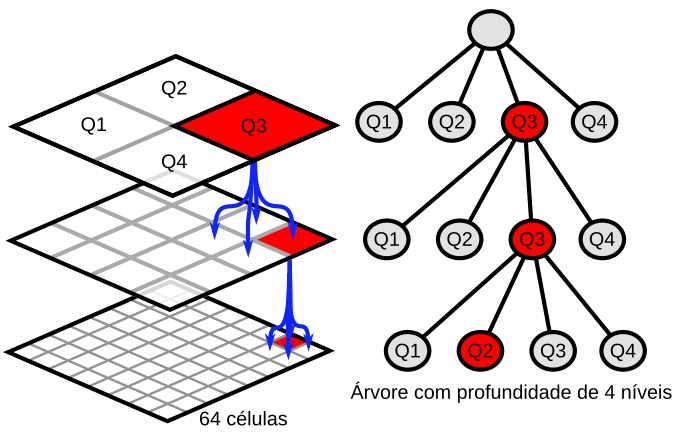

Nossa implementação é lenta pois foi construída para ser didática, mas existem formas de implementa-la com uma velocidade maior. Entre outras coisas, é possível implementar um [QuadTree][1] para acelerar a consulta aos nós vizinhos. Da forma que o algoritmo foi construído, cada consulta aos nós vizinhos precisará computar a distância do ponto x1 para cada outro ponto do conjunto e o algoritmo terá uma performance similar a $O(n^2)$. Um QuadTree exigira $O(log_{4} n}$ operações para ser montado e $O(log_{4} n)$ operações para cada consulta. Desta forma o algoritmo passaria a ter uma performance similar a $O(n \times log_{4} n)$. A figura acima permite entender o porque: Neste exemplo, em uma pesquisa sequencial são 64 células, em uma pesquisa por árvore são 4 níveis. Para 1 milhão de registros seriam 20 níveis e isto dá uma ideia da aceleração que um indexador como este pode oferecer.
  
[1]: https://en.wikipedia.org/wiki/Quadtree

## 2.3. Testes da implementação

O código abaixo gera o vídeo no início deste documento.

In [330]:
def bloco():
    
    %matplotlib inline
    from sklearn import datasets;
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    import IPython
    
    random.seed(13)
    
    X, yTrue = datasets.make_blobs(
        n_samples=1000,
        centers=[ [random.uniform(0,32), random.uniform(0,15) ] for i in range(7)], 
        n_features=2,
        random_state=5        
    )        

    fig = plt.figure(
        figsize=(12,5),
        dpi=100,
        frameon=False
    ) 

    hsv = plt.cm.get_cmap('hsv', 10)

    def anim_init():
        print('init')
        #ax.yaxis.get_major_locator().set_params(integer=True)    

    def anim_update( data ):     
        y, cores, cursor = data 
        print(cursor, end=';')

        #fig.patch.set_visible(False)        
        
        plt.clf()
        plt.title( f"Teste do DBScan com makeblobs (validação da rotina desenvolvida)")      
        #plt.xticks(())
        #plt.yticks(())
        #plt.box(False)

        ax = fig.subplots()
        ax.set_axis_off()
        plt.subplots_adjust(left=-0.001, right=1.001, top=1.005, bottom=-0.005)
        fig.patch.set_visible(False)
        ax.patch.set_visible(False)
        #ax.get_xaxis().set_ticks([])
        #ax.get_yaxis().set_ticks([])
        #ax.set_xlabel('random y (makeblobs)')
        #ax.set_ylabel('random y (makeblobs)')

        res = []

        ax.scatter(        
            [ X[j][0] for j in range(len(X)) if y[j]==0 ],
            [ X[j][1] for j in range(len(X)) if y[j]==0 ],        
            color='#c0c0c0',
            label='Outlier',
            marker='o',
            s=16
        )

        for i in range(1,10):
            ax.scatter(        
                [ X[j][0] for j in range(len(X)) if y[j]==i and cores[j]==0 ],
                [ X[j][1] for j in range(len(X)) if y[j]==i and cores[j]==0 ],        
                color=hsv(i),
                marker='o',
                s=4
            )
            ax.scatter(        
                [ X[j][0] for j in range(len(X)) if y[j]==i and cores[j]==1 ],
                [ X[j][1] for j in range(len(X)) if y[j]==i and cores[j]==1 ],        
                color=hsv(i),
                label=f'Cluster {i}',
                marker='o',
                s=32
            )

        if not( cursor is None ):
            ax.scatter(        
                [ cursor[0] ],
                [ cursor[1] ],        
                color='#000000',
                label='Cursor',
                marker='o',
                s=128
            )    

        ax.legend()

    anim = FuncAnimation(
        fig=fig,
        func=anim_update,
        frames=fit_dbscan_iterable(X,animFrames=100,animFramesAfter=30,animFramesBefore=10),
        save_count=140,
        interval=200,
        blit=False
    )
    video = anim.save('dbscan-example-blobs.mp4')
    #video = anim.to_html5_video()
    #html = IPython.display.HTML(video)
    IPython.display.clear_output(wait=True)       
    #IPython.display.display(html)

    plt.close() 
    
    IPython.display.clear_output(wait=True)       
    
bloco()

None;None;None;None;None;None;None;None;None;None;None;[16.44502141  4.35378185];[16.13267974  3.12002727];[16.7890049   4.68387802];[16.82447387  3.2345883 ];[16.57248739  2.9112362 ];[17.16357715  3.39824984];[16.96100175  2.53601643];[17.01939503  2.45858744];[17.44058215  2.53315802];[14.92621003  2.29667921];[18.13091465  2.92356044];[18.52659137  4.53958083];[18.36605511  2.32783671];[19.34019552  3.03512444];[20.51028915 14.8418191 ];[21.41467055 13.75095116];[21.65101498 13.46848549];[21.87162325 13.65570502];[21.08612353 12.59499064];[22.01976725 12.67814219];[22.78562232 12.56383905];[22.84096608 13.30304372];[22.81240909 12.3444508 ];[20.82120575 12.06585262];[21.14267288 11.57029527];[22.66988173 11.71535784];[21.82049025 11.23451927];[23.84421006 11.29940892];[21.96968193  2.42806329];[22.70911884  3.77289661];[22.94595335  2.31832478];[22.36762117  1.76221091];[23.52374916  2.6108807 ];[22.75416378  1.72895803];[24.25151376  3.07756814];[23.13666246  1.6345257 ];[21.86644

## 3. Exemplo com a base de casos e mortes de covid-19 por município nos Estados Unidos

Os dados usados usados nesta demonstração são de casos e mortes por covid19 por município dos Estados Unidos. 

In [112]:
def bloco():
    
    global df
    
    from datetime import datetime
    import pandas as pd
    import os
    pd.options.display.max_columns = None
        
    if os.path.isfile('/kaggle/input/us-counties-covid-19-dataset/us-counties.csv'):
        file = '/kaggle/input/us-counties-covid-19-dataset/us-counties.csv'
    elif os.path.isfile( 'data/us-counties-covid-19-dataset.csv' ):
        file = 'data/us-counties-covid-19-dataset.csv'
    else:
        raise Exception('Por favor, inclua o arquivo de dados em data/us-counties-covid-19-dataset.csv')
        
    df = pd.read_csv( file,
             #nrows=1000 
        )

    df.insert( 1, "wday", df['date'].apply( lambda x: int(datetime.strptime(x,'%Y-%m-%d').strftime('%w')) ) )
    df.insert( 1, "mday", df['date'].apply( lambda x: int(datetime.strptime(x,'%Y-%m-%d').strftime('%d')) ) )
    #df.insert( 1, "month", df['date'].apply( lambda x: int(datetime.strptime(x,'%Y-%m-%d').strftime('%m')) ) )

    df = df.dropna()
    df = df.sample( 1500 )
    
    #df['wday'] = (df['wday'] - df['wday'].mean())/df['wday'].std()
    #df['cases'] = (df['cases'] - df['cases'].mean())/df['cases'].std()
    #df['deaths'] = (df['deaths'] - df['deaths'].mean())/df['deaths'].std()
    
    return df
    
bloco()

,date,mday,wday,county,state,fips,cases,deaths
37912,2020-04-06,6,1,Rutland,Vermont,50021.0,28,0
1903,2020-03-13,13,5,Loudoun,Virginia,51107.0,3,0
44747,2020-04-09,9,4,Cape May,New Jersey,34009.0,109,3
402,2020-03-01,1,0,Marin,California,6041.0,1,0
42527,2020-04-08,8,3,Stephens,Oklahoma,40137.0,11,1
...,...,...,...,...,...,...,...,...
7076,2020-03-21,21,6,Monongalia,West Virginia,54061.0,1,0
27238,2020-04-02,2,4,Koochiching,Minnesota,27071.0,1,0
38393,2020-04-07,7,2,Yuba,California,6115.0,13,0
1842,2020-03-13,13,5,Marion,Oregon,41047.0,2,0


## 4. Exemplo COVID19

No exemplo abaixo, procuramos agrupamentos entre casos e mortes.

A animação abaixo ilustra como os pontos vão se reposicionando. Em cada iteração o modelo encontra os pontos mais próximos do centroide e reposiciona o centroide no centro dos pontos selecionados. Isto faz o modelo espalhar os pontos.


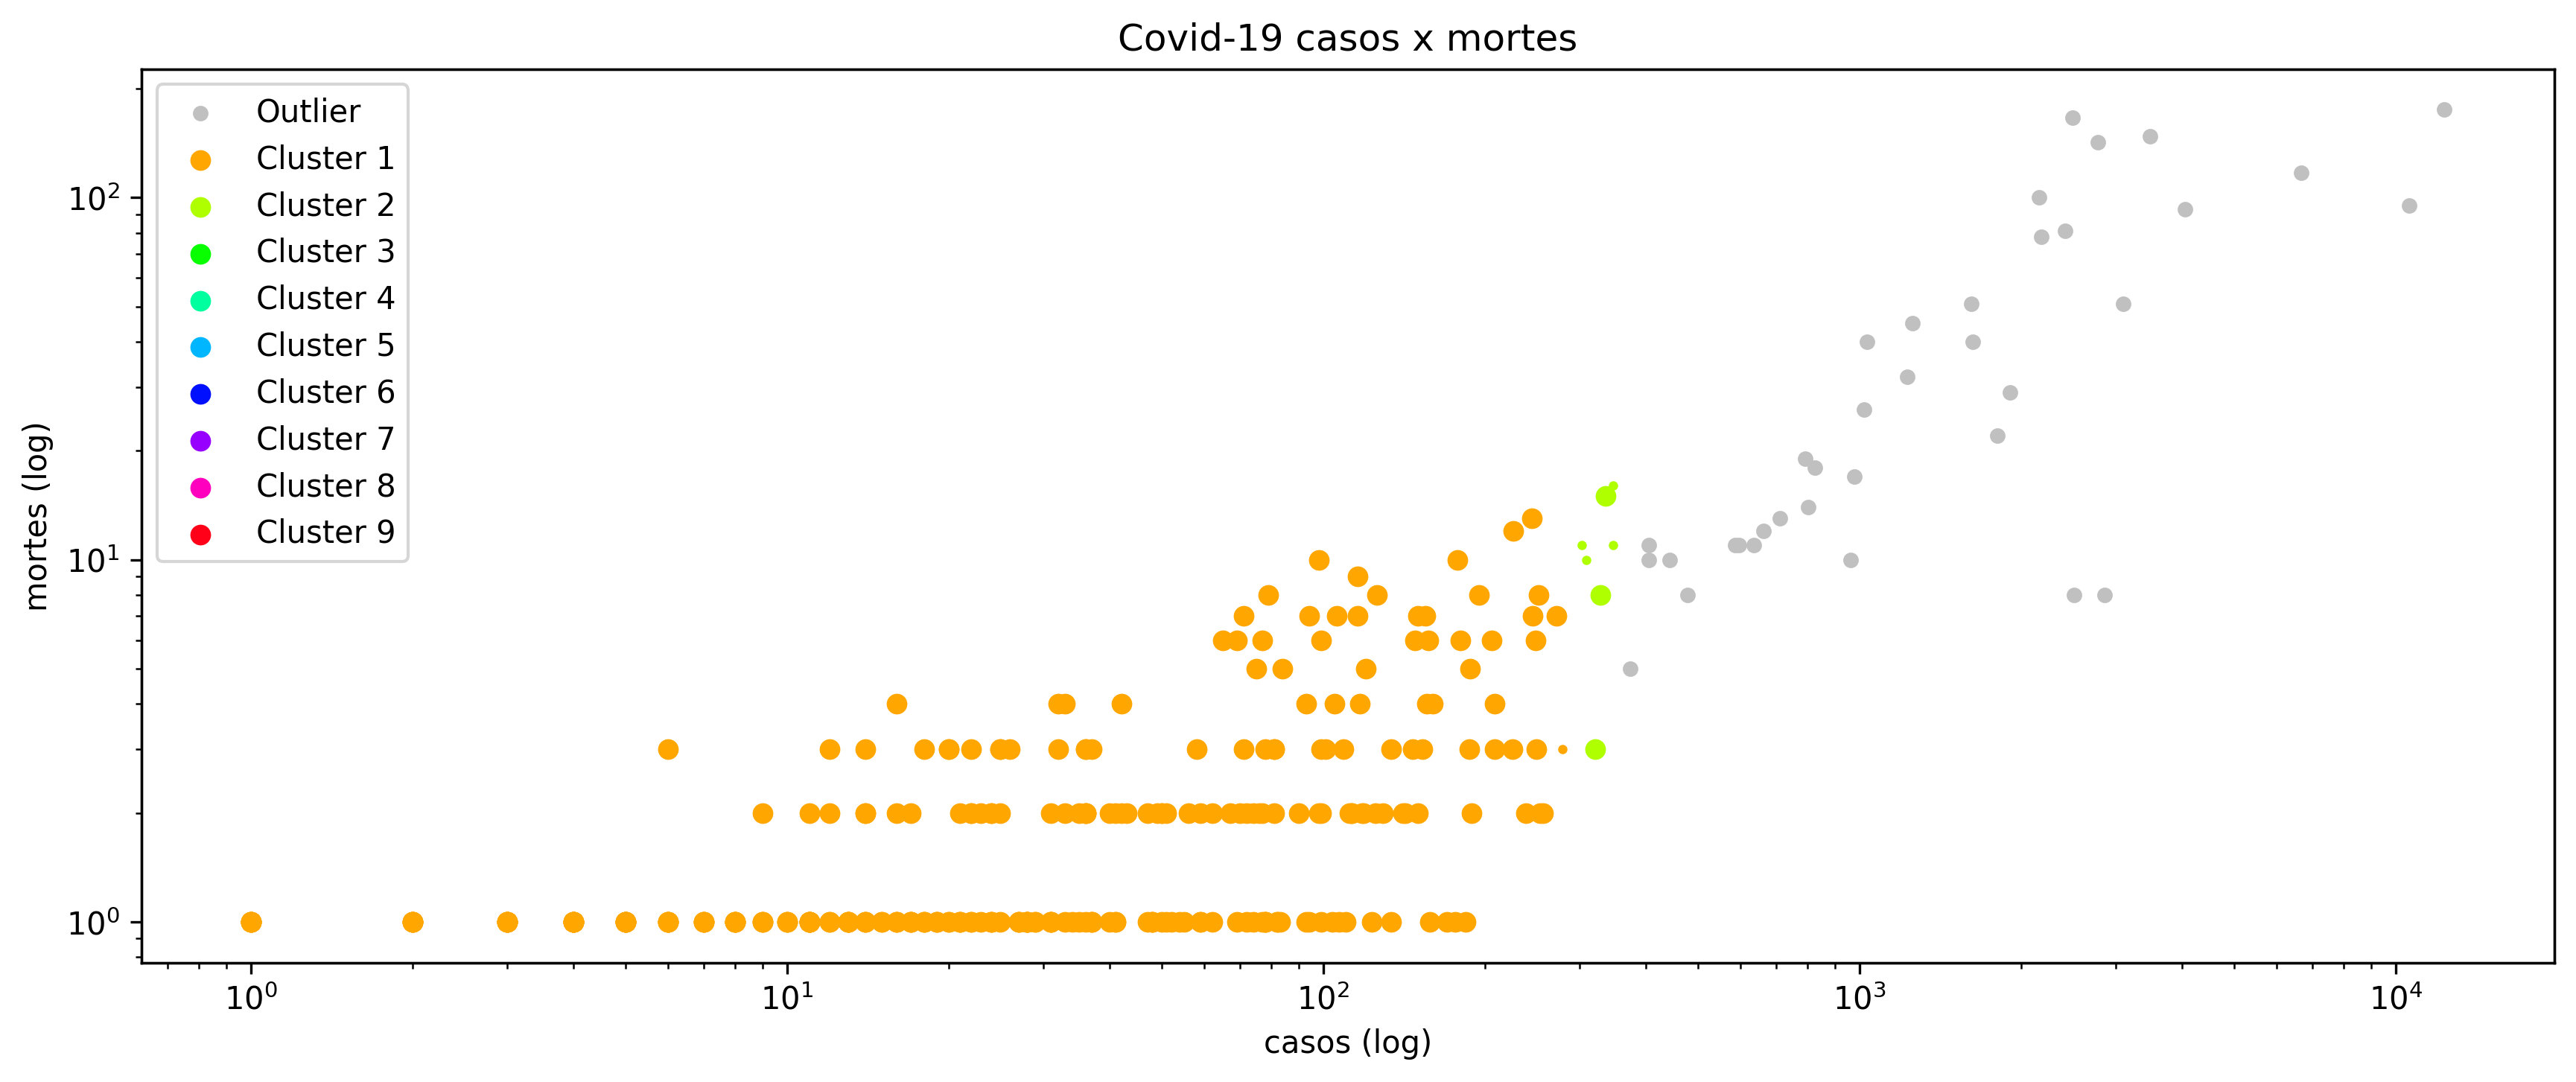

In [340]:
def bloco():
    
    %matplotlib inline
    from sklearn import datasets;
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    import IPython
    
    X = df[ [ 'cases','deaths' ] ].to_numpy()    
    y, cores, cursor = fit_dbscan(X,radius=20,minPts=5,anim=False)
    
    fig = plt.figure(figsize=(12,5),dpi=300)

    hsv = plt.cm.get_cmap('hsv', 10)

    plt.clf()
    plt.title( f"Covid-19 casos x mortes")      
    plt.xticks(())
    plt.yticks(())

    ax = fig.subplots()
    ax.yaxis.get_major_locator().set_params(integer=True)    
    ax.set_xlabel('casos (log)')
    ax.set_ylabel('mortes (log)')

    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)

    #plt.xlim(-0.5,5)
    #plt.ylim(-0.5,5)
    plt.yscale('log')
    plt.xscale('log')        
    res = []

    ax.scatter(        
        [ X[j][0] for j in range(len(X)) if y[j]==0 ],
        [ X[j][1] for j in range(len(X)) if y[j]==0 ],        
        color='#c0c0c0',
        label='Outlier',
        marker='o',
        s=16
    )

    for i in range(1,10):
        ax.scatter(        
            [ X[j][0] for j in range(len(X)) if y[j]==i and cores[j]==0 ],
            [ X[j][1] for j in range(len(X)) if y[j]==i and cores[j]==0 ],        
            color=hsv(i),
            marker='o',
            s=4
        )
        ax.scatter(        
            [ X[j][0] for j in range(len(X)) if y[j]==i and cores[j]==1 ],
            [ X[j][1] for j in range(len(X)) if y[j]==i and cores[j]==1 ],        
            color=hsv(i),
            label=f'Cluster {i}',
            marker='o',
            s=32
        )

    if not( cursor is None ):
        ax.scatter(        
            [ cursor[0] ],
            [ cursor[1] ],        
            color='#000000',
            label='Cursor',
            marker='o',
            s=128
        )    

    ax.legend()

    plt.show()
    
bloco()

In [151]:
import os
#os.remove("dbscan-example-blobs.mp4")
#os.remove("dbscan-example-covid19.mp4")